In [ ]:
!pip install --upgrade keras-nlp -q
!pip install --upgrade keras -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatibl

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import keras
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab.drive import mount

mount("/content/drive")

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Sentiment-Analysis/dataset/sentiment_analysis_data_seimbang.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Comment     36000 non-null  object 
 1   cleaned     36000 non-null  object 
 2   tokenized   36000 non-null  object 
 3   normalized  36000 non-null  object 
 4   sentiment   36000 non-null  object 
 5   score       36000 non-null  float64
dtypes: float64(1), object(5)
memory usage: 1.6+ MB


In [ ]:
df.head()

,Comment,cleaned,tokenized,normalized,sentiment,score
0,Terima kasih sudah mencerdaskan bangsa dengan ...,terima kasih mencerdaskan bangsa data fakta,"['terima', 'kasih', 'mencerdaskan', 'bangsa', ...",terima kasih mencerdaskan bangsa data fakta,positive,0.953096
1,Iya bener,iya bener,"['iya', 'bener']",iya benar,positive,0.778663
2,Emng boleh seoercaya itu,emng seoercaya,"['emng', 'seoercaya']",memang seoercaya,positive,0.991190
3,Ga ada bagusnya...🙉...yg di wawancara ga berkelas,bagusnya wawancara berkelas,"['bagusnya', 'wawancara', 'berkelas']",bagusnya wawancara berkelas,positive,0.993296
4,Denger gibahan ini mah.. ngga banget.. fokus a...,denger gibahan mah ngga banget fokus memperbai...,"['denger', 'gibahan', 'mah', 'ngga', 'banget',...",dengar gibahan mah enggak banget fokus memperb...,positive,0.729036


In [ ]:
df = df[["normalized", "sentiment"]]

In [ ]:
df["label"] = df["sentiment"].map({"positive": 2, "neutral": 1, "negative": 0})

df.head()

,normalized,sentiment,label
0,terima kasih mencerdaskan bangsa data fakta,positive,2
1,iya benar,positive,2
2,memang seoercaya,positive,2
3,bagusnya wawancara berkelas,positive,2
4,dengar gibahan mah enggak banget fokus memperb...,positive,2


### Bi-LSTM & Bi-LSTM & Attention Modeling


In [ ]:
vocab_size = 20_000
max_length = 512
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [ ]:
tokenizer.fit_on_texts(df["normalized"])

In [ ]:
len(tokenizer.word_index)

32478

In [ ]:
sequences = tokenizer.texts_to_sequences(df["normalized"])
padded = keras.utils.pad_sequences(
    sequences=sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

In [ ]:
padded[:5]

array([[   30,    27,   180, ...,     0,     0,     0],
       [  153,    58,     0, ...,     0,     0,     0],
       [   67, 14095,     0, ...,     0,     0,     0],
       [ 3139,  3140,  4355, ...,     0,     0,     0],
       [  954, 14096,   296, ...,     0,     0,     0]], dtype=int32)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((padded, df["label"].values)).batch(64)
shuffled = dataset.shuffle(len(dataset), seed=42)

train_size = int(len(shuffled) * 0.8)
val_size = int(len(shuffled) * 0.1)

train = shuffled.take(train_size).cache().prefetch(tf.data.AUTOTUNE)
validation = shuffled.skip(train_size).take(val_size).cache().prefetch(tf.data.AUTOTUNE)
test = shuffled.skip(train_size + val_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
len(train), len(test)

(450, 57)

In [ ]:
for x, y in train.take(1):
    print(x, y)

tf.Tensor(
[[14548   142   297 ...     0     0     0]
 [ 6692   205   409 ...     0     0     0]
 [  204     7    89 ...     0     0     0]
 ...
 [   51    21  1234 ...     0     0     0]
 [   29 10120    24 ...     0     0     0]
 [ 1828    20   589 ...     0     0     0]], shape=(64, 512), dtype=int32) tf.Tensor(
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2], shape=(64,), dtype=int64)


In [ ]:
def create_bilstm_model(vocab_size, output_size):
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=[1]),
            keras.layers.Embedding(
                vocab_size, 512, embeddings_regularizer=keras.regularizers.l2(1e-6)
            ),
            keras.layers.Dropout(0.2),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    64,
                    return_sequences=True,
                    kernel_regularizer=keras.regularizers.l2(1e-6),
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    128,
                    return_sequences=True,
                    kernel_regularizer=keras.regularizers.l2(1e-6),
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(256, kernel_regularizer=keras.regularizers.l2(1e-6))
            ),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(output_size, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-5, weight_decay=0.01),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        jit_compile=True,
    )

    return model

In [ ]:
def create_attention_model(vocab_size, output_size):
    # Input layer
    input = keras.layers.Input(shape=(512,))
    embeddings = keras.layers.Embedding(
        vocab_size, 512, embeddings_regularizer=keras.regularizers.l2(1e-6)
    )(input)
    dropout = keras.layers.Dropout(0.2)(embeddings)

    # Bi-LSTM
    lstm = keras.layers.Bidirectional(
        keras.layers.LSTM(
            64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(1e-6)
        )
    )(dropout)

    # Attention
    norm = keras.layers.LayerNormalization()(lstm)
    attention = keras.layers.Attention(dropout=0.1)([norm, norm])

    for _ in range(2):
        norm = keras.layers.LayerNormalization()(attention)
        attention = keras.layers.Attention(dropout=0.1)([norm, norm])

    # Fully connected
    fc = keras.layers.Flatten()(attention)
    fc = keras.layers.Dropout(0.2)(fc)
    output = keras.layers.Dense(output_size, activation="softmax")(fc)

    model = keras.models.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-5, weight_decay=0.01),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        jit_compile=True,
    )

    return model

In [ ]:
bilstm_model = create_bilstm_model(vocab_size, 3)
attention_model = create_attention_model(vocab_size, 3)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py:205: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


In [ ]:
bilstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1, 512)              │      10,240,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 128)              │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1, 256)              │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 512)                 │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,850,755 (45.21 MB)

 Trainable params: 11,850,755 (45.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
attention_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 512, 512)       │     10,240,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512, 512)       │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 512, 128)       │        295,424 │ dropout_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 512, 128)       │            256 │ bidirectional_3[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 512, 128)       │              0 │ layer_normalization[0… │
│                           │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 512, 128)       │            256 │ attention[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 512, 128)       │              0 │ layer_normalization_1… │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 512, 128)       │            256 │ attention_1[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 512, 128)       │              0 │ layer_normalization_2… │
│                           │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 65536)          │              0 │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 65536)          │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 3)              │        196,611 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,732,803 (40.94 MB)

 Trainable params: 10,732,803 (40.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 100
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/Sentiment-Analysis/Checkpoints/bilstm.weights.h5",
        save_weights_only=True,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    ),
]

In [ ]:
bilstm_history = bilstm_model.fit(
    train, validation_data=validation, epochs=epochs, callbacks=callbacks
)

bilstm_model.save_weights("/content/drive/MyDrive/Sentiment-Analysis/Weights/bilstm.weights.h5")

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 114s 217ms/step - loss: 1.1081 - sparse_categorical_accuracy: 0.3414 - val_loss: 1.0556 - val_sparse_categorical_accuracy: 0.5179 - learning_rate: 5.0000e-05
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 135s 218ms/step - loss: 0.9555 - sparse_categorical_accuracy: 0.5570 - val_loss: 0.7739 - val_sparse_categorical_accuracy: 0.6203 - learning_rate: 5.0000e-05
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 101s 224ms/step - loss: 0.7167 - sparse_categorical_accuracy: 0.6796 - val_loss: 0.6086 - val_sparse_categorical_accuracy: 0.7369 - learning_rate: 5.0000e-05
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 141s 222ms/step - loss: 0.5523 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.5144 - val_sparse_categorical_accuracy: 0.7902 - learning_rate: 5.0000e-05
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 142s 223ms/step - loss: 0.4588 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.4615 - val_sparse_categorical_accuracy: 0.8200 - learning_rate: 5.0000e-05
Epoch

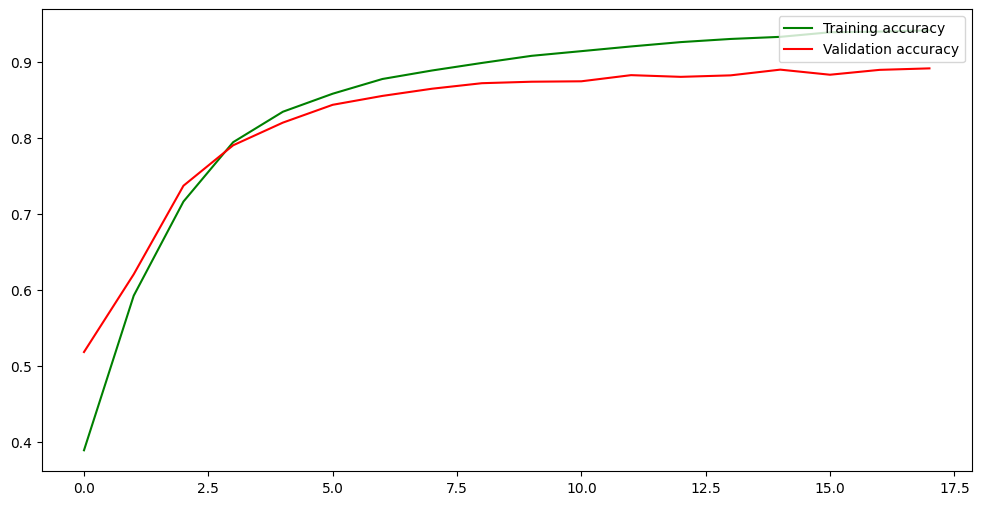

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(
    bilstm_history.history["sparse_categorical_accuracy"],
    c="g",
    label="Training accuracy",
)
plt.plot(
    bilstm_history.history["val_sparse_categorical_accuracy"],
    c="r",
    label="Validation accuracy",
)
plt.legend(loc=1)

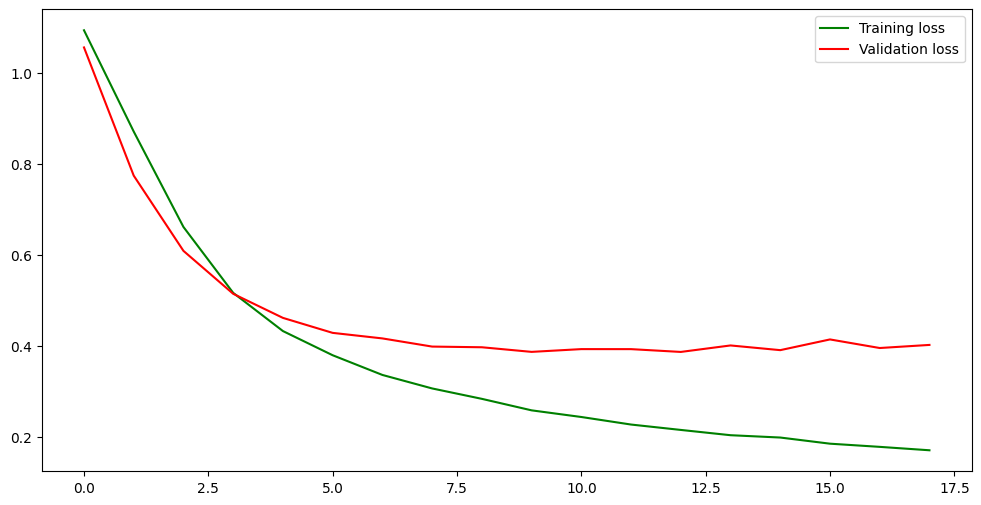

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(bilstm_history.history["loss"], c="g", label="Training loss")
plt.plot(bilstm_history.history["val_loss"], c="r", label="Validation loss")
plt.legend(loc=1)

In [ ]:
callbacks[-1] = keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Checkpoints/attention.weights.h5",
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

attention_history = attention_model.fit(
    train, validation_data=validation, epochs=epochs, callbacks=callbacks
)

attention_model.save_weights("/content/drive/MyDrive/Sentiment-Analysis/Weights/attention.weights.h5")

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 65s 133ms/step - loss: 2.4321 - sparse_categorical_accuracy: 0.3499 - val_loss: 1.2459 - val_sparse_categorical_accuracy: 0.3449 - learning_rate: 5.0000e-05
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - loss: 1.3739 - sparse_categorical_accuracy: 0.4483 - val_loss: 0.9703 - val_sparse_categorical_accuracy: 0.5153 - learning_rate: 5.0000e-05
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 61s 135ms/step - loss: 1.0132 - sparse_categorical_accuracy: 0.5733 - val_loss: 0.7630 - val_sparse_categorical_accuracy: 0.6493 - learning_rate: 5.0000e-05
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 82s 135ms/step - loss: 0.7797 - sparse_categorical_accuracy: 0.6697 - val_loss: 0.6688 - val_sparse_categorical_accuracy: 0.7146 - learning_rate: 5.0000e-05
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 61s 135ms/step - loss: 0.6477 - sparse_categorical_accuracy: 0.7291 - val_loss: 0.5686 - val_sparse_categorical_accuracy: 0.7799 - learning_rate: 5.0000e-05


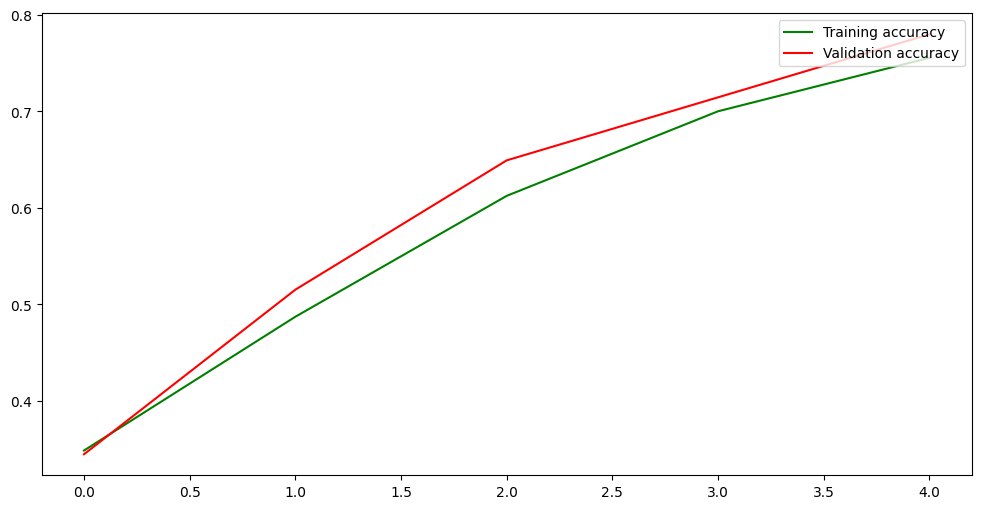

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(
    attention_history.history["sparse_categorical_accuracy"],
    c="g",
    label="Training accuracy",
)
plt.plot(
    attention_history.history["val_sparse_categorical_accuracy"],
    c="r",
    label="Validation accuracy",
)
plt.legend(loc=1)

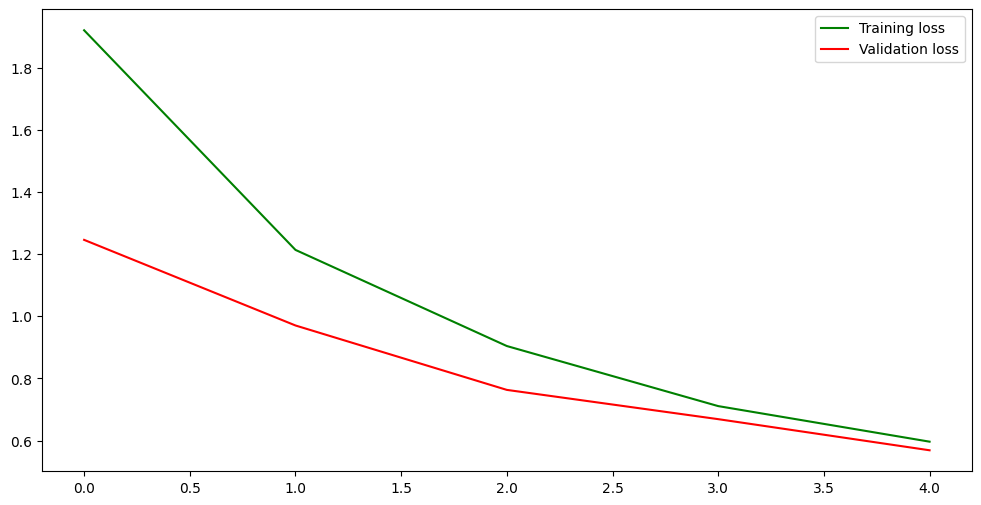

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(
    attention_history.history["loss"],
    c="g",
    label="Training loss",
)
plt.plot(
    attention_history.history["val_loss"],
    c="r",
    label="Validation loss",
)
plt.legend(loc=1)

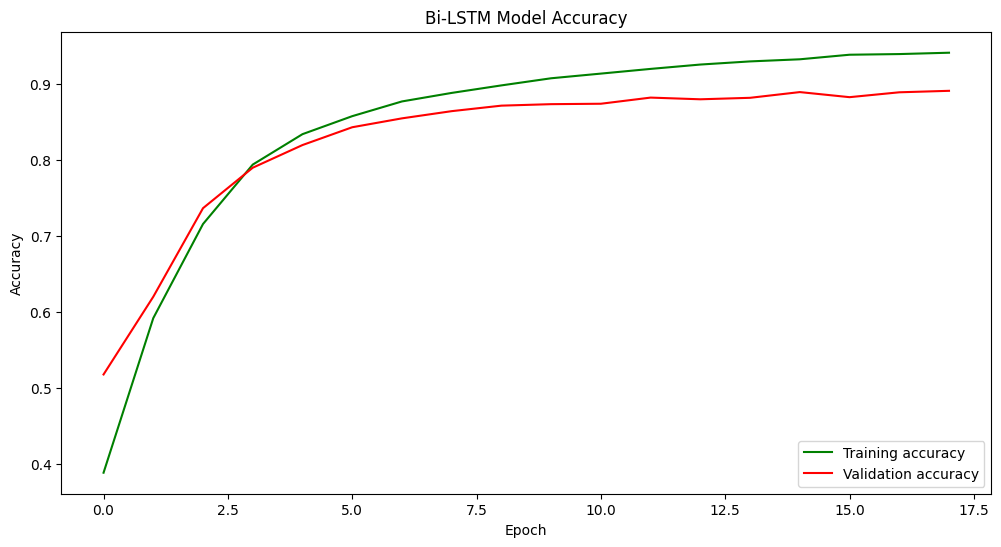

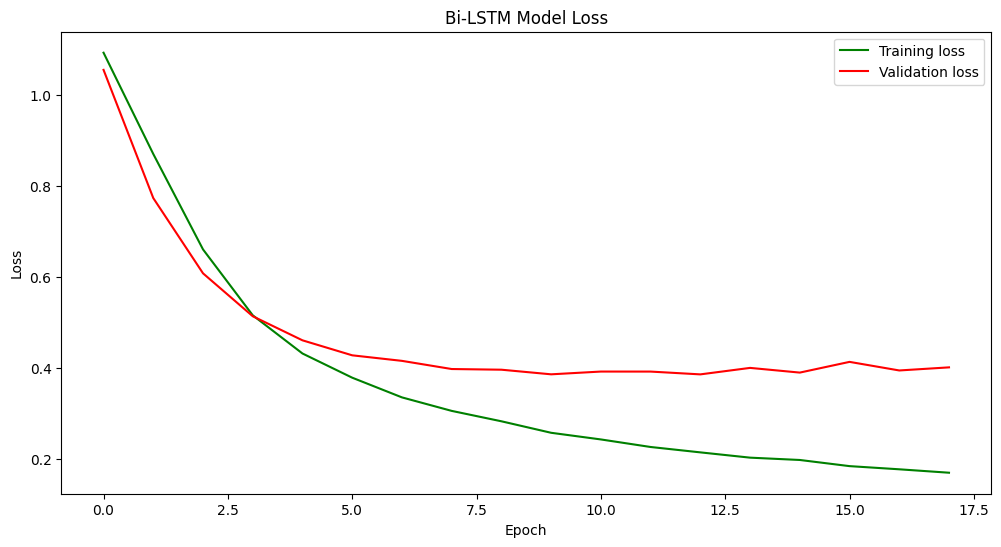

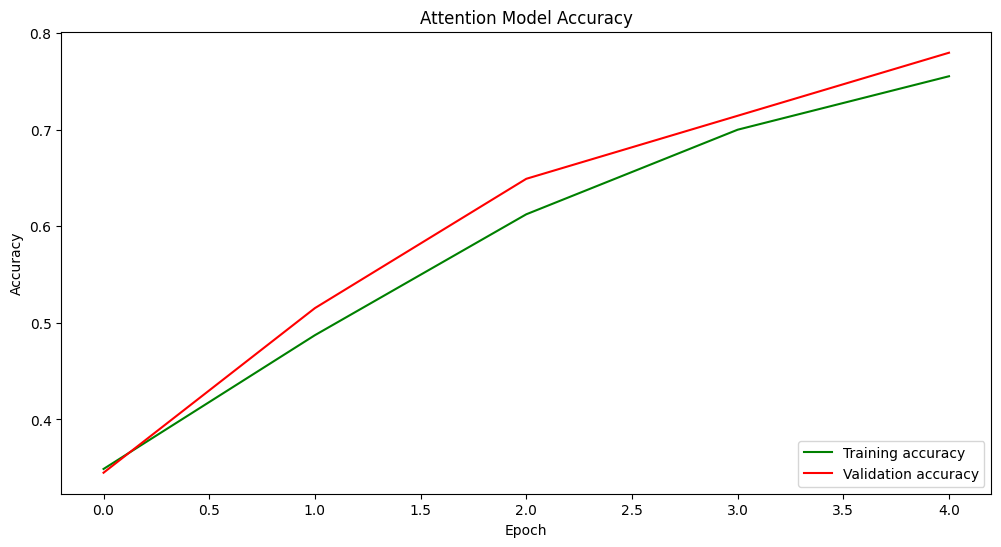

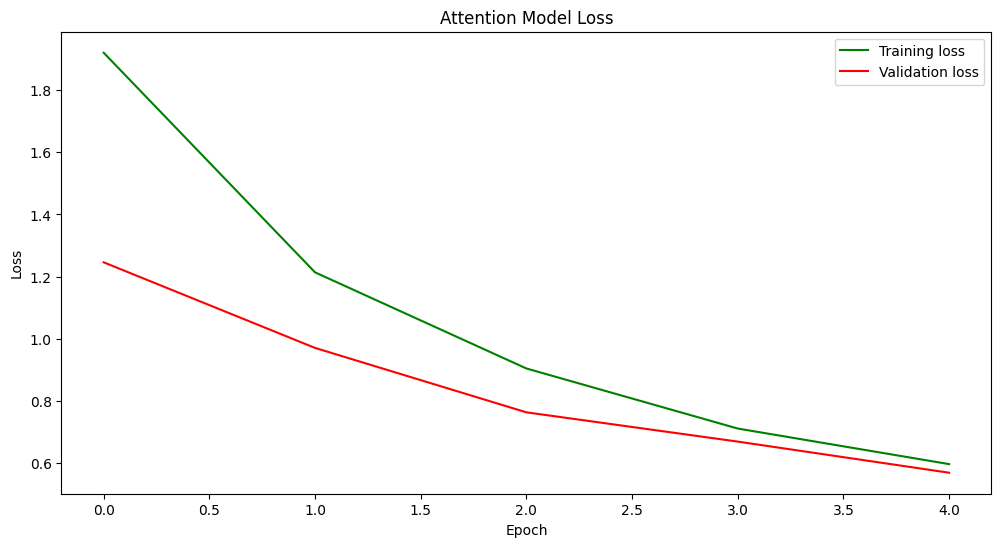

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(bilstm_history.history["sparse_categorical_accuracy"], c="g", label="Training accuracy")
plt.plot(bilstm_history.history["val_sparse_categorical_accuracy"], c="r", label="Validation accuracy")
plt.title("Bi-LSTM Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(bilstm_history.history["loss"], c="g", label="Training loss")
plt.plot(bilstm_history.history["val_loss"], c="r", label="Validation loss")
plt.title("Bi-LSTM Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(attention_history.history["sparse_categorical_accuracy"], c="g", label="Training accuracy")
plt.plot(attention_history.history["val_sparse_categorical_accuracy"], c="r", label="Validation accuracy")
plt.title("Attention Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(attention_history.history["loss"], c="g", label="Training loss")
plt.plot(attention_history.history["val_loss"], c="r", label="Validation loss")
plt.title("Attention Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step


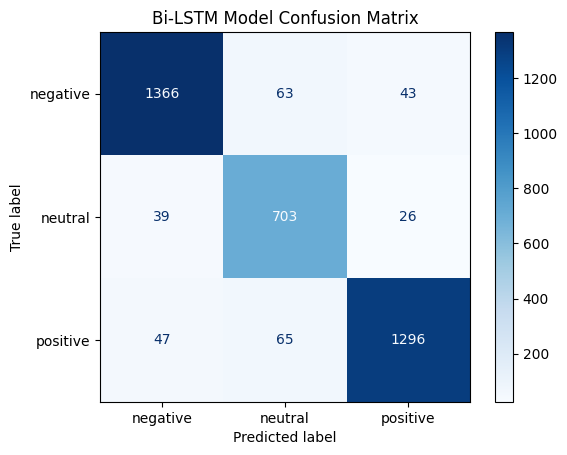

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


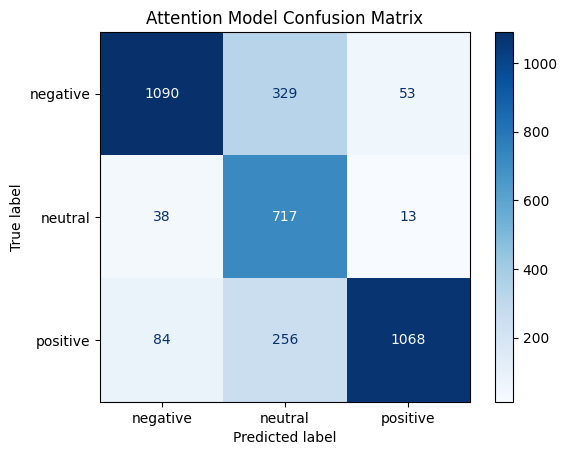

In [ ]:
y_pred_bilstm = bilstm_model.predict(test.map(lambda x, y: x))
y_pred_bilstm = tf.argmax(y_pred_bilstm, axis=1).numpy()
y_true_bilstm = tf.concat([y for x, y in test], axis=0).numpy()

cm_bilstm = confusion_matrix(y_true_bilstm, y_pred_bilstm, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bilstm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Bi-LSTM Model Confusion Matrix")
plt.show()

y_pred_attention = attention_model.predict(test.map(lambda x, y: x))
y_pred_attention = tf.argmax(y_pred_attention, axis=1).numpy()
y_true_attention = tf.concat([y for x, y in test], axis=0).numpy()

cm_attention = confusion_matrix(y_true_attention, y_pred_attention, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_attention, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Attention Model Confusion Matrix")
plt.show()

In [ ]:
bilstm_model.load_weights("/content/drive/MyDrive/Sentiment-Analysis/Weights/bilstm.weights.h5")
attention_model.load_weights("/content/drive/MyDrive/Sentiment-Analysis/Weights/attention.weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def predict_sentiment(text, model):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = keras.utils.pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    prediction = model.predict(padded_sequences)
    label = tf.argmax(prediction, axis=1).numpy()[0]
    sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
    return sentiment_map[label]

user_input = "saya suka presiden yang korupsi"
bilstm_sentiment = predict_sentiment(user_input, bilstm_model)
attention_sentiment = predict_sentiment(user_input, attention_model)

print(f"Bi-LSTM Model Prediction: {bilstm_sentiment}")
print(f"Attention Model Prediction: {attention_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Bi-LSTM Model Prediction: negative
Attention Model Prediction: positive


In [ ]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip install --upgrade scikit-learn scikeras

<ipython-input-46-1eef98d7b3a3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


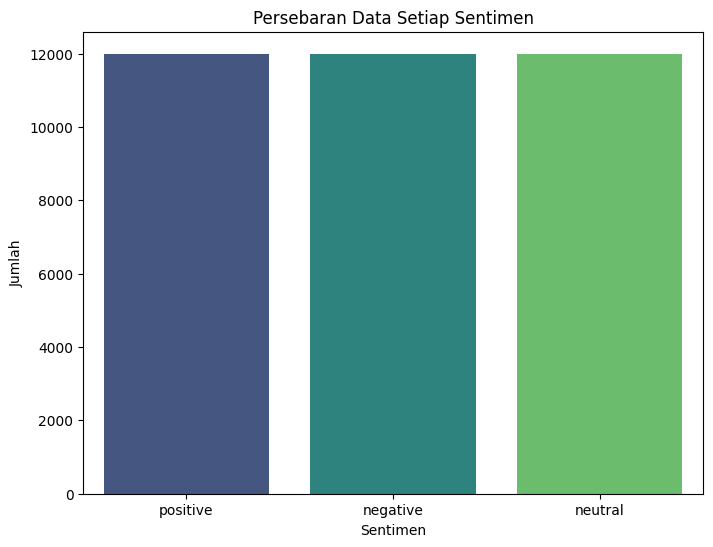

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Persebaran Data Setiap Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()


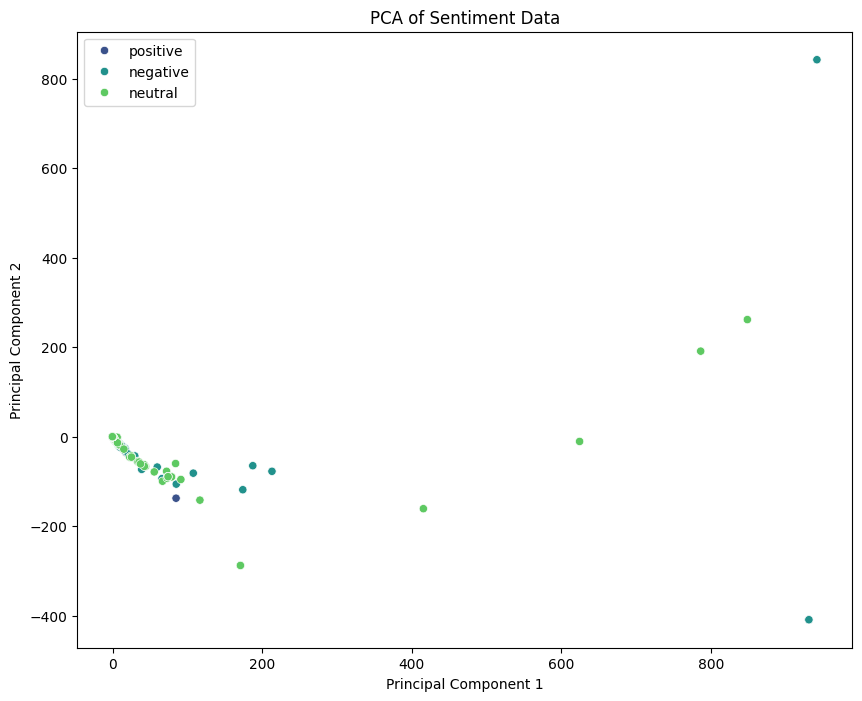

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Muat dataset
df = pd.read_csv("/content/drive/MyDrive/Sentiment-Analysis/dataset/sentiment_analysis_data_seimbang.csv")

# Tambahkan kolom 'label' yang memetakan sentimen ke nilai numerik
df['label'] = df['sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})

# Tokenisasi dan padding
vocab_size = 20000
max_length = 512
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df['normalized'])

sequences = tokenizer.texts_to_sequences(df['normalized'])
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Standarisasi data
scaler = StandardScaler()
padded_scaled = scaler.fit_transform(padded)

# PCA Transformasi
pca = PCA(n_oversamples=1000, n_components=2)
pca_result = pca.fit_transform(padded_scaled)

# Buat DataFrame dengan hasil PCA
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['sentiment'] = df['sentiment']

# Visualisasikan hasil PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='sentiment', data=pca_df, palette='viridis')
plt.title('PCA of Sentiment Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.show()
